<a href="https://colab.research.google.com/github/ketanp23/sit-neuralnetworks-class/blob/main/sltandapproximation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This code demonstrates the core concepts of Statistical Learning Theory (SLT) using a simple neural network to approximate a sine function with noise.

Here's a breakdown of the code:

Import Libraries: Imports necessary libraries like NumPy for numerical operations, Matplotlib for plotting, PyTorch for building and training the neural network, and scikit-learn for splitting data.

generate_data function: Creates synthetic data based on the sine function with added Gaussian noise. This simulates a real-world scenario where we have data points generated from an underlying process, but they are not perfectly clean.

SimpleMLP class: Defines a basic Multi-Layer Perceptron (MLP) with one hidden layer. The hidden_size parameter allows for varying the complexity (capacity) of the model. A larger hidden_size means a more complex model.
train_model function:

Takes training and testing data, hidden_size, epochs, and learning rate as input.
Converts NumPy arrays to PyTorch tensors.
Initializes the SimpleMLP model, defines the Mean Squared Error (MSE) as the loss function (empirical risk), and uses Stochastic Gradient Descent (SGD) as the optimizer.
Trains the model for a specified number of epochs.

Evaluates the trained model on both the training and testing data to calculate the empirical risk (train MSE) and an approximation of the expected risk (test MSE).
main function:

Generates the synthetic data.

Splits the data into training and testing sets using train_test_split.
Defines a list of hidden_sizes (model complexities) to experiment with.

Iterates through the different hidden_sizes, trains a model for each, and stores the results (empirical risk, approximate expected risk, and generalization gap).

Plots the original noisy data, the true sine function, and the learned approximations for each model complexity. The plot helps visualize how the model fits the data.

Prints the calculated SLT metrics for each hidden size, showing the relationship between model complexity, empirical risk, and expected risk (generalization gap).

In essence, the code visually and numerically demonstrates that a more complex model (larger hidden_size) can achieve lower empirical risk (better fit on training data) but might have a larger generalization gap (difference between test and train error), illustrating the trade-off between model capacity and generalization in SLT.



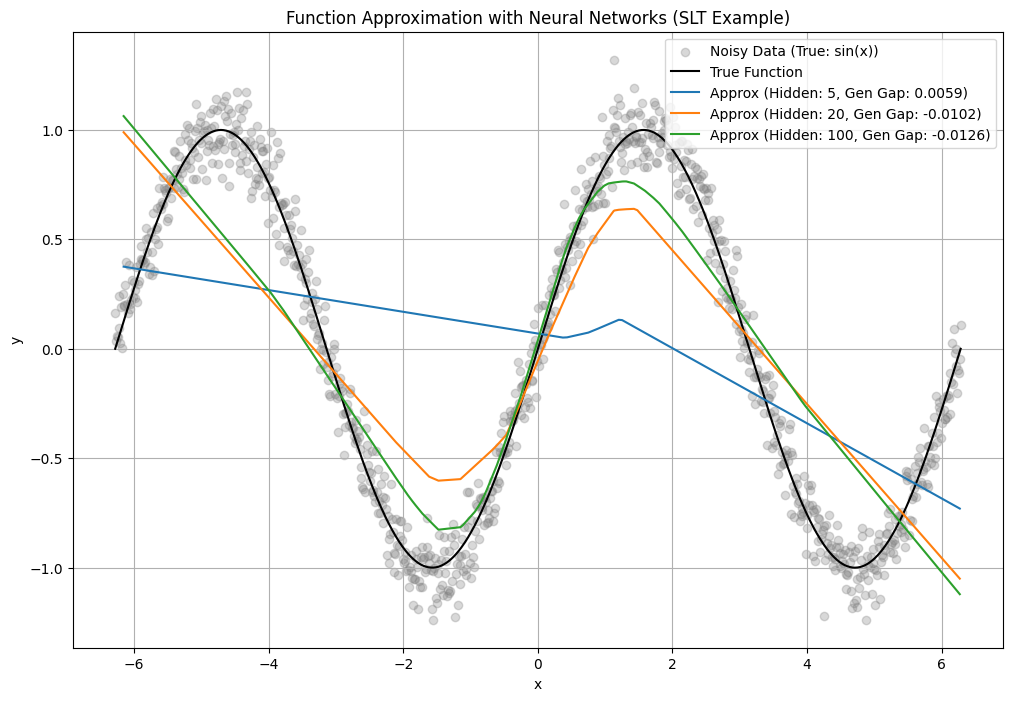


SLT Metrics:
Hidden Size 5:
  Empirical Risk (Train MSE): 0.4007
  Approx Expected Risk (Test MSE): 0.4066
  Generalization Gap: 0.0059
---
Hidden Size 20:
  Empirical Risk (Train MSE): 0.1664
  Approx Expected Risk (Test MSE): 0.1562
  Generalization Gap: -0.0102
---
Hidden Size 100:
  Empirical Risk (Train MSE): 0.1380
  Approx Expected Risk (Test MSE): 0.1254
  Generalization Gap: -0.0126
---


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split

# Step 1: Generate synthetic data for approximation (e.g., y = sin(x) + noise)
# This represents the true function we want to approximate.
def generate_data(n_samples=1000, noise_std=0.1):
    x = np.linspace(-2 * np.pi, 2 * np.pi, n_samples)
    y = np.sin(x) + np.random.normal(0, noise_std, n_samples)
    return x, y

# Step 2: Define a simple Multi-Layer Perceptron (MLP) for function approximation
# Vary hidden_size to show model complexity (SLT concept: capacity affects generalization)
class SimpleMLP(nn.Module):
    def __init__(self, hidden_size=10):
        super(SimpleMLP, self).__init__()
        self.fc1 = nn.Linear(1, hidden_size)  # Input: 1 feature (x)
        self.fc2 = nn.Linear(hidden_size, 1)  # Output: 1 value (y)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Step 3: Train the model and compute risks
def train_model(X_train, y_train, X_test, y_test, hidden_size, epochs=500, lr=0.01):
    # Convert to PyTorch tensors
    X_train_t = torch.tensor(X_train, dtype=torch.float32).unsqueeze(1)
    y_train_t = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1)
    X_test_t = torch.tensor(X_test, dtype=torch.float32).unsqueeze(1)
    y_test_t = torch.tensor(y_test, dtype=torch.float32).unsqueeze(1)

    # Initialize model, loss, optimizer
    model = SimpleMLP(hidden_size)
    criterion = nn.MSELoss()  # Mean Squared Error for regression (empirical risk)
    optimizer = optim.SGD(model.parameters(), lr=lr)

    # Training loop
    for epoch in range(epochs):
        model.train()
        optimizer.zero_grad()
        outputs = model(X_train_t)
        loss = criterion(outputs, y_train_t)  # Empirical risk on training data
        loss.backward()
        optimizer.step()

    # Evaluate
    model.eval()
    with torch.no_grad():
        train_preds = model(X_train_t)
        test_preds = model(X_test_t)
        emp_risk = criterion(train_preds, y_train_t).item()  # Empirical risk (train MSE)
        exp_risk = criterion(test_preds, y_test_t).item()    # Approximate expected risk (test MSE)

    return model, emp_risk, exp_risk, X_test_t, test_preds

# Step 4: Main function to demonstrate SLT and Approximate Learning
def main():
    # Generate data
    x, y = generate_data(n_samples=1000)

    # Split into train/test (80/20) to evaluate generalization
    X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

    # Experiment with different model complexities (hidden sizes)
    hidden_sizes = [5, 20, 100]  # Low, medium, high complexity
    results = {}

    plt.figure(figsize=(12, 8))
    plt.scatter(x, y, color='gray', alpha=0.3, label='Noisy Data (True: sin(x))')
    plt.plot(x, np.sin(x), color='black', label='True Function')

    for hs in hidden_sizes:
        model, emp_risk, exp_risk, X_test_t, test_preds = train_model(X_train, y_train, X_test, y_test, hidden_size=hs)

        # Sort for smooth plotting
        sorted_indices = torch.argsort(X_test_t.squeeze())
        X_sorted = X_test_t.squeeze()[sorted_indices]
        preds_sorted = test_preds.squeeze()[sorted_indices]

        plt.plot(X_sorted.numpy(), preds_sorted.numpy(), label=f'Approx (Hidden: {hs}, Gen Gap: {exp_risk - emp_risk:.4f})')

        results[hs] = {
            'Empirical Risk (Train MSE)': emp_risk,
            'Approx Expected Risk (Test MSE)': exp_risk,
            'Generalization Gap': exp_risk - emp_risk
        }

    plt.title('Function Approximation with Neural Networks (SLT Example)')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.legend()
    plt.grid(True)
    plt.show()

    # Print results to illustrate SLT concepts
    print("\nSLT Metrics:")
    for hs, metrics in results.items():
        print(f"Hidden Size {hs}:")
        for key, value in metrics.items():
            print(f"  {key}: {value:.4f}")
        print("---")

# Run the demo
if __name__ == "__main__":
    main()